In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import scienceplots
%matplotlib inline

from nanonets.utils import prepare_for_fitness_calculation, fitness, abundance, abundance_plot, get_best_logic_gate

PATH    = "/home/jonasmensing/bagheera/data/2_funding_period/static/res_disorder/T5/"
PATH_U  = "/home/jonasmensing/bagheera/data/1_funding_period/system_size_scaled/T5/"
V_IN    = 0.01
DELTA   = 0.01
GATES   = ['AND', 'OR', 'XOR', 'NAND', 'NOR', 'XNOR']
plt.style.use(["science","bright","grid"])

In [4]:
data    = {}
df_u    = pd.read_csv(f"{PATH_U}Nx=9_Ny=9_Ne=8.csv")
df_u    = prepare_for_fitness_calculation(df_u, N_e=8, input_cols=["E1","E3"])
for i in range(64):
    df      = pd.read_csv(f"{PATH}Nx=9_Ny=9_Ne=8_{i}.csv")
    df      = prepare_for_fitness_calculation(df, N_e=8, input_cols=["E1","E3"])
    data[i] = df

In [24]:
fitness_data_u      = fitness(df_u, input_cols=["E1","E3"], on_state=0.01, delta=DELTA)
abundance_data_u    = abundance(fitness_data_u)
fitness_data        = {key : fitness(df, input_cols=["E1","E3"], on_state=0.01, delta=DELTA) for key, df in data.items()}
abundance_data      = {key : abundance(df) for key, df in fitness_data.items()}

In [25]:
fitness_data_comb = pd.DataFrame()
for i in range(64):
    fitness_data_comb = pd.concat((fitness_data_comb, fitness_data[i]), ignore_index=True)
abundance_data_comb = abundance(fitness_data_comb)

In [26]:
df1 = fitness_data_comb.loc[:,'AND Fitness':]
df1.columns = GATES
df1 = df1.melt(var_name='Gate', value_name='$Fitness$')
df1['Disorder'] = True

df2 = fitness_data_u.loc[:,'AND Fitness':]
df2.columns = GATES
df2 = df2.melt(var_name='Gate', value_name='$Fitness$')
df2['Disorder'] = False

fitness_melted = pd.concat([df1,df2],ignore_index=True)
fitness_melted

,Gate,$Fitness$,Disorder
0,AND,3.316489,True
1,AND,2.113490,True
2,AND,1.840620,True
3,AND,3.572081,True
4,AND,2.449795,True
...,...,...,...
1975825,XNOR,0.568390,False
1975826,XNOR,0.186071,False
1975827,XNOR,-0.772619,False
1975828,XNOR,0.310553,False


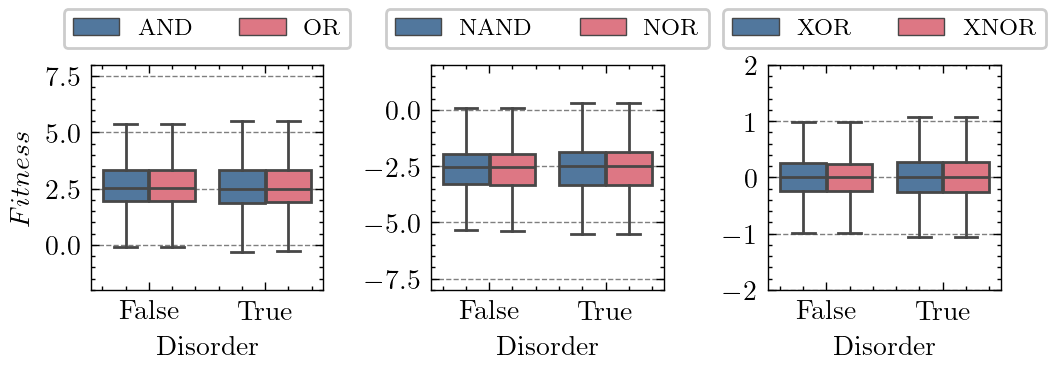

In [27]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.5)
fig.set_figheight(fig.get_figheight()*0.7)

for i, g_comb in enumerate([['AND','OR'],['NAND','NOR'],['XOR','XNOR']]):

    ax  = fig.add_subplot(1,3,i+1)
    ax  = sns.boxplot(data=fitness_melted[(fitness_melted['Gate']==g_comb[0])|(fitness_melted['Gate']==g_comb[1])],
                      x='Disorder', y='$Fitness$', hue='Gate', ax=ax, fliersize=0)
    leg = ax.legend(loc='center', bbox_to_anchor=(0.5,1.16), ncol=2, fontsize='small')
    leg.set_in_layout(True)
    if i != 0:
        ax.set_ylabel("")
    if i == 0:
        ax.set_ylim(-2,8)
    elif i == 1:
        ax.set_ylim(-8,2)
    else:
        ax.set_ylim(-2,2)

In [11]:
df_comp = pd.DataFrame()
for i in range(64):
    df1 = fitness_data[i].loc[:,'AND Fitness':]
    df1.columns = GATES
    df1 = df1.melt(var_name='Gate', value_name='$Fitness$')
    df1['Disorder'] = i
    df_comp = pd.concat((df_comp,df1),ignore_index=True)

df1 = fitness_data_u.loc[:,'AND Fitness':]
df1.columns = GATES
df1 = df1.melt(var_name='Gate', value_name='$Fitness$')
df1['Disorder'] = -1

df_comp = pd.concat([df_comp, df1], ignore_index=True)
df_comp

,Gate,$Fitness$,Disorder
0,AND,4.279753,0
1,AND,2.490010,0
2,AND,2.159208,0
3,AND,4.392160,0
4,AND,3.387724,0
...,...,...,...
1975825,XNOR,0.737066,-1
1975826,XNOR,0.211011,-1
1975827,XNOR,-0.909063,-1
1975828,XNOR,0.350337,-1


Text(0.5, 0, '$\\sigma_F$')

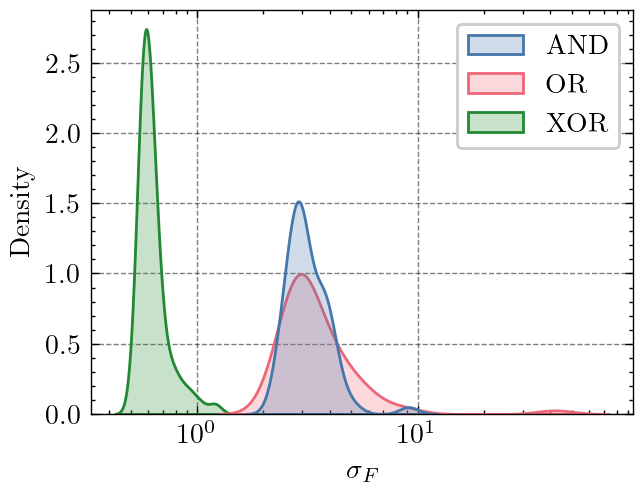

In [12]:
df = pd.DataFrame([[fitness_data[i][f'{gate} Fitness'].std() for i in range(64)] for gate in ['AND','OR','XOR']]).T
df.columns = ['AND','OR','XOR']
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.kdeplot(df, ax=ax, log_scale=True, fill=True)
ax.set_xlabel("$\sigma_F$")

(-2.0, 2.0)

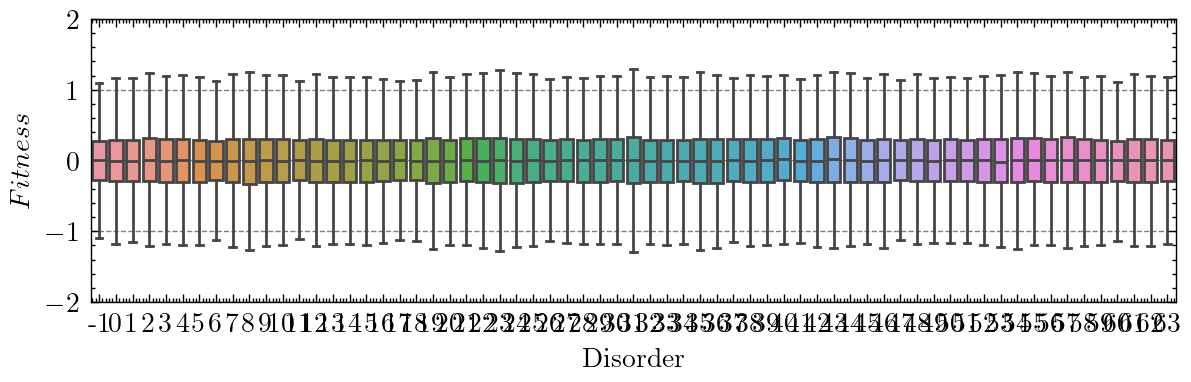

In [14]:
gate = 'XOR'

fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*2.0)
fig.set_figheight(fig.get_figheight()*0.7)
ax  = fig.add_subplot()
ax  = sns.boxplot(data=df_comp[df_comp['Gate']==gate], x='Disorder', y='$Fitness$', ax=ax, fliersize=0)
ax.set_ylim(-2,2)

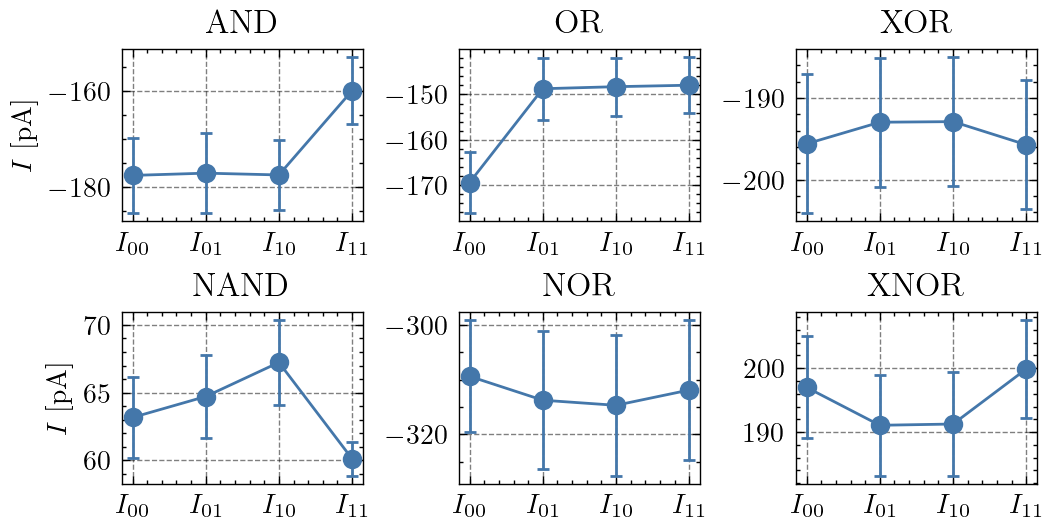

In [15]:
n   = 12
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.5)
for i, gate in enumerate(GATES):
    ax = fig.add_subplot(2,3,i+1)
    best_gate = get_best_logic_gate(data[n], fitness_data[n], gate)
    ax.errorbar([0,1,2,3], best_gate['Observable'].values*1e-6, best_gate['Error'].values*1e-6, marker='o', capsize=2)
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(["$I_{00}$","$I_{01}$","$I_{10}$","$I_{11}$"])
    ax.set_title(gate)
    if i % 3 == 0:
        ax.set_ylabel("$I$ [pA]")